**Sandia 34 Meter VAWT Example:**

Plan: 
- Get all of the geometry specifics
- Get all of the structural and aerodynamic properties (whether precomputed or add code to do the computation on the fly)
- Extract the needed validation data
- Get the plots working all nice and pretty here, with all the bugs worked out
- Turn this into an aerostructural test case


**Geometry Specifics**

We get the global geometry from SAND-91-2228 as specified in the snippet from the report below. However, we need the detailed geometry for the 1.22, 1.07, and 0.91 meter chord airfoil extrusions.

<img src="./figs/SNL34m_global_geom.png" alt="drawing" width="400"/>

Now we compare the shape to parabolic (used the matlab "grabit" script from the file exchange to hand pick the points from the image above)

**!!For now we will assume!!:**

**- The blade mountpoint ratio is 0.5 (i.e the blade is centered about the rotation axis)**


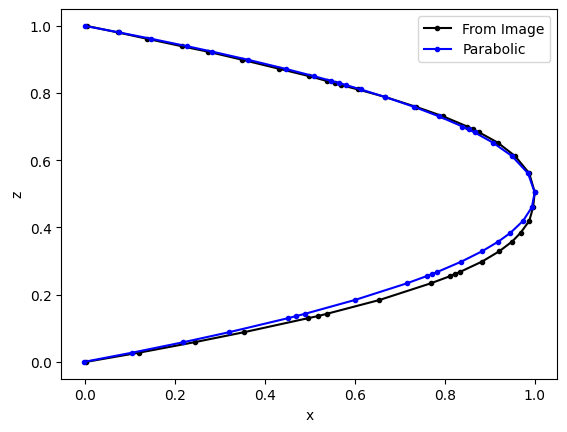

PyObject <matplotlib.legend.Legend object at 0x148ee9cd0>

In [9]:
import DelimitedFiles
import PyPlot


SNL34_unit_xz = DelimitedFiles.readdlm("./data/SNL34m_unit_blade_shape.txt",'\t',skipstart = 0)

#Ensure the data is fully unitized since the hand picking process is only good to one or two significant digits.
SNL34x = SNL34_unit_xz[:,1]./maximum(SNL34_unit_xz[:,1])
SNL34z = SNL34_unit_xz[:,2]./maximum(SNL34_unit_xz[:,2])

# And let's compare this with a true parabolic shape using the SNL34m Z as the input
R = 1.0
height = 1.0
parabolic_x = R.*(1.0.-4.0.*(SNL34z/height.-.5).^2)

PyPlot.figure()
PyPlot.plot(SNL34x,SNL34z,"k.-")
PyPlot.plot(parabolic_x,SNL34z,"b.-")
PyPlot.xlabel("x")
PyPlot.ylabel("z")
PyPlot.legend(["From Image","Parabolic"])

From this we can see (as is also shown in the specs of the image) that the blade is not parabolic, but has a mounting angle 2.5 degrees larger at the base than the top.  Let's go ahead and use the original geometry.  To smooth things out and make it more tractable for parametric design studies and optimization, let's spline it, but not before extracting the transition points that I conveniently market by the center of a group of three.

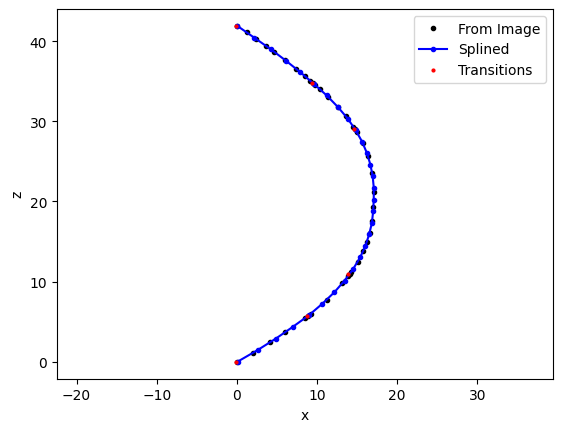

(-0.9772074142462533, 17.960819400678396, -2.123493806637175, 43.996356847935104)

In [23]:
import FLOWMath

#Scale the turbine to the full dimensions
height = 41.9 #m
radius = 17.1 #m
SNL34Z = SNL34z*height
SNL34X = SNL34x*radius

# Transitions 
idx = [1,6,11,24,31,40]
z_transitions = [SNL34Z[idx[1]],SNL34Z[idx[2]],SNL34Z[idx[3]],SNL34Z[idx[4]],SNL34Z[idx[5]],SNL34Z[idx[6]]]
x_transitions = [SNL34X[idx[1]],SNL34X[idx[2]],SNL34X[idx[3]],SNL34X[idx[4]],SNL34X[idx[5]],SNL34X[idx[6]]]

# Create the spline, and for simplicity, we will not use the exact transition points in the mesh
npt = 30
spl_z = LinRange(0,height,npt)
spl_x = FLOWMath.akima(SNL34Z,SNL34X,spl_z)

PyPlot.figure()
PyPlot.plot(SNL34X,SNL34Z,"k.")
PyPlot.plot(spl_x,spl_z,"b.-")
PyPlot.plot(x_transitions.-0.15,z_transitions,"r.",markersize = 4.0)
PyPlot.xlabel("x")
PyPlot.ylabel("z")
PyPlot.legend(["From Image","Splined","Transitions"])
PyPlot.axis("equal")

Now that we have the blade shape and transition points, we can create the mesh

In [ ]:
import OWENS


mesh = OWENS.create_mesh(;Ht = 0.0, #tower height before blades attach
    Hb = height, #blade height
    R = radius, # m bade radius
    nstrut = 2, #strut elements
    strut_mout_ratio = 0.01, #distance from top/bottom
    ntelem = 20, #tower elements
    nbelem = 20, #blade elements
    nselem = 2,  #strut elements
    bshapex = SNL34X, #Blade shape, magnitude is irrelevant, scaled based on height and radius above
    bshapez = SNL34Z) #Blade shape, magnitude is irrelevant, scaled based on height and radius above

figure()



In Summary TODO:

||Wall Thickness|Rib Thickness|Number Extrusions|Nose Thickness|Tail Thickness|
|---|---|---|---|---|---|---|

We get the aluminum blade extrusion geometries from SAND-84-1287

<img src="./figs/Extrusion_1.22m.png" alt="drawing" width="800"/>

Extracting some data from within the report text, we learn that:

"The blade sections will be constructed of multiple extrusions (Figure 10). The maximum size of each extrusion is limited by the size of the extruding press available; the largest single extrusion blade that can be fabricated today is -0.74 m (29 in.) in chord. The 1.22-m (48-in.) chord NACA 0021 blade profile shown in this figure will be fabricated from three extrusions, all with 0.79-cm (0.31 -in.) wall and rib thicknesses. The 1.07-m (42-in.) and 0.91-m (36-in.) chord SAND 0018/50 blade sections will use two extrusions each, with 0.64-cm (0.25 -in.) wall and rib thicknesses. The nose of each blade section is 1.27 cm (0.50 in,) thick, and the tail is filled, as illustrated in the drawing."

In Summary:

|Chord Length/Section|Airfoil|Wall Thickness|Rib Thickness|Number Extrusions|Nose Thickness|Tail Thickness|
|---|---|---|---|---|---|---|
|1.22m|NACA 0021|0.0079m|0.0079m|3|0.0127m|filled|
|1.07m|SAND 0018/50|0.0064m|0.0064m|2|0.0127m|filled|
|0.91m|SAND 0018/50|0.0064m|0.0064m|2|0.0127m|filled|

**!!For now we will assume!!:**

**- the ribs are equidistant and of similar scale and numer for all three sections**